<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/281assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Projective Transform

MIDS W281: Computer Vision

## Recommended Libraries

In [69]:
import numpy as np
from math import sin, cos
import matplotlib.pyplot as plt
from PIL import Image
import os
import imageio
import copy

## Part 1: Pole Height

![Hybrid Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_1/pole_length.png)

### Overview
Single-view metrology corresponds to a set of techniques for making 3-D measurements from a single 2-D image. Such measurements have several applications including, for example, measuring the height of a suspect in a crime-scene image. We will consider a simple scenario of single-view metrology estimating 3-D measurements of objects in a rendered 2-D image.

### Description

Consider the image shown in Figure 1. You are given the following information about the 3-D scene. There are three poles colored yellow, green, and blue, and a ground plane in this scene. The three poles are perpendicular to the ground plane. The ground plane is parallel to the X-Z plane, and the camera's optical axis is parallel to the Z-axis. Standing at 4 meters, the yellow and green poles are of the same height in the 3-D scene. The distance between these two poles is 17 meters. The green and blue poles are at the same, but unknown, distance from the camera. Finally, the resolution of the image sensor of the camera is 53,333 pixels per meter.

Recall the perspective projection equation that tells us the relationship between a point's location in the 3-D world (X,Y,Z), the camera focal length (f), and the projection of that point in the image (x,y):  
$$\frac{x}{X}=\frac{f}{Z}$$
and
$$\frac{y}{Y}=\frac{f}{Z}$$
&nbsp;

Write a python script to measure the heights and distances between the poles in image coordinates. You may use the pixel locations provided below to estimate the location of the pole endpoints in the image:

$$yellow = [[518, 391],  [512, 987]]$$
$$green = [[733, 462],  [732, 771]]$$
$$blue = [[1189, 311], [1189, 769]]$$

From these image measurements and the 3-D quantities specified above, you will be able to determine the camera focal length and 3-D height of the blue pole.

In [70]:
pixel_density_per_meter = 53333
Y_ylw = 4
Y_grn = 4

# Yellow pole, image coordinate system
x_ylw_x1, x_ylw_x2 = 518, 512
y_ylw_y1, y_ylw_y2 = 391, 987

# Green pole, image coordinate system
x_grn_x1, x_grn_x2 = 733, 732
y_grn_y1, y_grn_y2 = 462, 771

# Blue pole, image coordinate system
x_blu_x1, x_blu_x2 = 1189, 1189
y_blu_y1, y_blu_y2 = 311, 769

# Heights in image coordinate system in pixels
y_ylw = np.sqrt((x_ylw_x1 - x_ylw_x2) ** 2 + (y_ylw_y1 - y_ylw_y2) ** 2) 
y_grn = np.sqrt((x_grn_x1 - x_grn_x2) ** 2 + (y_grn_y1 - y_grn_y2) ** 2) 
y_blu = np.sqrt((x_blu_x1 - x_blu_x2) ** 2 + (y_blu_y1 - y_blu_y2) ** 2) 

Z_ylw = -1 * (17 * y_grn / Y_grn) / ((y_grn/Y_grn) - (y_ylw/Y_ylw))
f_in_mm = ((y_ylw * Z_ylw / Y_ylw ) / pixel_density_per_meter) * 1000
Z_blu = Z_ylw + 17
Z_grn = Z_blu + 17
Y_blu_in_meter = (y_blu * Z_blu / f_in_mm) / pixel_density_per_meter
y_ylw, y_grn, y_blu, Z_ylw, f_in_mm, Y_blu_in_meter

(596.0302005771184,
 309.0016181187406,
 458.0,
 18.301409089738772,
 51.13247206514212,
 0.005928771542212488)

### Deliverables:

Using the above perspective projection equations, **compute and report**:
- Camera focal length f (in mm) : 51.13247 mm
- 3-D height (Y) of blue pole (in m) : 5.92877 m

## Part 2: Dolly Zoom

![Hybrid Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_1/dollys_zoom.gif)

### Overview
Wikipedia defines a dolly zoom (also known as a Hitchcock shot, Vertigo shot, Jaws effect, or Zolly shot) as an in-camera effect that appears to undermine normal visual perception. This effect has been used in many famous [movies](https://www.youtube.com/watch?v=u5JBlwlnJX0). In this part, you will create a simple 3-D scene and simulate the dolly-zoom effect, similar to that shown in Figure 2. This exercise will help you gain familiarity with transforming points between world and sensor coordinates and learn how to use Python image manipulation techniques.

### Description: 
The dolly-zoom effect is accomplished by simultaneously adjusting the camera focal length and the distance between the camera and object of interest. Specifically, the effect can be achieved by moving the camera toward the object while simultaneously reducing the camera focal length such that the object remains the same size in the image and the background appears to change in volume relative to the object.

In order to implement this effect, you will create a simple 3-D scene with four planes and a cube, as in Figure 2. For creating this 3-D scene, you are given the following information. 

Assume that your camera is looking in the positive Z-direction and has an initial camera focal-length of 300 mm. 

You are given the cordinates of the four corners of a fronto-parallel plane (i.e., perpendicular to camera's optical axis) with height and width equal to 400 m:  

$$plane=[[0,0,0], [400,0,0], [400,400,0], [0,400,0]]$$  

You are also given the cordinates of a cube of edge length 12 m and centered at the origin:

$$cube=[[−6,−6,−6], [6,−6,−6], [6,6,−6], [−6,6,−6], [−6,−6,6], [6,−6,6], [6,6,6], [−6,6,6]]$$

Note that both these objects are specified with respect to their own local cordinate systems with the origin at one of their vertices. In order to place the ground plane and cube in the relative locations shown in Figure 2, you need to apply the following rotation and translation to the ground plane and cube:

$$ground:{Rx=90, Ry=0, Rz=0, Tx=−200, Ty=−30, Tz=100}$$
$$cube:{Rx=30, Ry=30, Rz=0, Tx=0, Ty=0, Tz=100}$$

By convention, the order of operations for 3D rotations is $$R = Rz * Ry *Rx$$.

Below we've provided starter code for generating the checkerboard grid pattern, visualizing the scene, constructing the scene objects, and rendering each frame into a movie. In order to create the dolly-zoom animation shown in Figure 2 you will do the following:

1. **Parse:** First you must write code to construct a transformation matrix from the given rotation, translation, and focal length parameters above. 
Fill in the `get_projective_matrix` function below. This requires parsing the input transformation parameters, constructing both the intrinsic and extrinsic matrices, and combining these together in the correct order. You must also complete the `transform_points` function by filling in the conversion step from transformed homogeneous points to non-homogenous sensor points.


2. **Place:** We have only provided the specification for the ground plane and the cube. You must create and place the other three planes by specifying their rotations and translations. 
In the script below, fill in the correct transformation matrices for the back plane and the two side planes. All planes should be aligned exactly at their edges, should be the same size, and should not overlap or become disjointed as the camera parameters change. Make sure the entire scene is visible in the plot.


3. **Compute:** Calculate the necessary focal lengths and transformations required to achieve the dolly zoom effect. 
The dolly zoom requires that you must move the camera and adjust the focal length together such that the cube stays roughly the same size in the projected image. (That is, conceptually, a horizontal line parallel to the image plane and running through the center of the cube would not change in length during the entire dolly zoom.) Write a function to calculate the necessary relationship between Z and f that achieves this effect.


4. **Dolly:** After the 3-D scene is created, start moving the camera forward.  
Move the camera forward while simultaneously adjusting the focal length. Note that moving the camera forward is the same as moving the entire scene towards the camera. Starting with an initial camera-to-cube distance of 100 meters and an initial focal length of 300 mm, and move the camera in 30 steps to a final camera-to-cube distance of 40 meters. Use your formula from step 3 to compute the necessary focal length for each frame and transform the scene accordingly. Submit the resulting GIF along with your code.

### Deliverables:

- Implementation of transformation matrix construction
- Object placement in the scene
- Implementation of dolly zoom calculation
- Dolly zoom animation gif

In [71]:
# import helper functions
# !!! Be sure to review the helper functions in utilityCode !!!
from utilityCode import *

#### Setup Functions

In [72]:
# scene parameters as provided in the assignment

f_start = 0.3 # the focal length f to start
grid_count = 20 # the number of squares in one dimension of the plane
Z_start = 100 # the starting distance between the camera and the cube
Z_end = 40 # the last distance between camera and the cube
steps = 30 # number of dolly zoom steps to take between Z_start and Z_end

In [73]:
""" Given desired transformation parameters and focal length,
    construct both the intrinsic and extrinsic matrix,
    then return the full transformation matrix
    Input parameter format: [Rx, Ry, Rz, Tx, Ty, Tz] """

def get_projective_matrix(in_trns, f):
    
    ## TODO: parse transformation params
    # rotation params (radians)
    # translation params
    
    ## TODO: construct extrinsic matrix
    # combine X, Y, and Z rotations
    # append translation values
    
    ## TODO: construct intrinsic matrix
    
    ## TODO multiply intrinsic and extrinsic matrix and return M
    return


""" Given an object, transform its points using its transform parameters, 
    then project it onto the sensor (f is the focal length for constructing the intrinsic matrix) """

def transform_points(in_obj, f):
    
    out_obj = dict(in_obj)
    
    XYZ = in_obj['points'].copy()
    in_trns = in_obj['transform'].copy()
    
    # perspective projection
    M = get_projective_matrix(in_trns, f)
    
    # projection (homogenous coordinates)
    p = M @ np.transpose(XYZ) 
    
    ## TODO: convert p to non-homogenous sensor coordinates x and y (rescale)
    # x = ???
    # y = ???
    
    # put the sensor points in the output object
    out_obj['points'] = np.hstack(( x[:, np.newaxis], y[:, np.newaxis] ))
    
    return out_obj
    

#### Scene Construction

KeyError: ignored

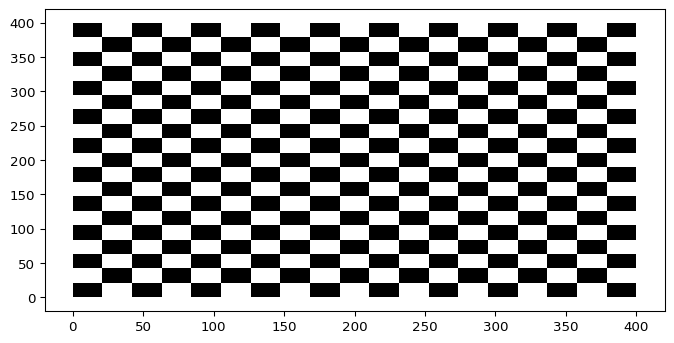

In [77]:
""" We will use a scene dictionary with keys as object names 
    Each object will have its own keys containing object-specific points and transformation matrix"""

# 3-D, unit-cube (homogenous coordinates)
cube = np.array([ [0,0,0,1], [1,0,0,1], [1,1,0,1], [0,1,0,1],
                  [0,0,1,1], [1,0,1,1], [1,1,1,1], [0,1,1,1]])

# make length of the cube 12 meters
cube[:, :3] = 12 * cube[:, :3]
cube[:, :3] = cube[:, :3] - 6

height = 400 # height of the walls
plane = np.array([ [0,0,0,1], [height,0,0,1], [height,height,0,1], [0,height,0,1] ])

# create an empty scene
scene = {}
scene['ground_plane'] = {}
scene['right_plane'] = {}
scene['left_plane'] = {}
scene['back_plane'] = {}
scene['cube'] = {}

""" assign the points and transformations (Rx, Ry, Rz, Tx, Ty, Tz) """

# setup ground plane and transformation
# put the points and transformation (Rx, Ry, Rz, Tx, Ty, Tz)
scene['ground_plane']['points'] = np.reshape( get_plane_mesh(plane, grid_count), (-1, 4) )
scene['ground_plane']['transform'] = np.array( [90, 0, 0, -height/2, -30, Z_start] )

scene['right_plane']['points'] = np.reshape( get_plane_mesh(plane, grid_count), (-1, 4) )
## TODO: Adjust the transformation parameters for right side plane
# scene['right_plane']['transform'] = ???
scene['right_plane']['transform'] = np.array( [-90, 0, 0, -height/2, -30, Z_start] )

scene['left_plane']['points'] = np.reshape( get_plane_mesh(plane, grid_count), (-1, 4) )
## TODO: Adjust the transformation parameters for left side plane
# scene['left_plane']['transform'] =  ???
scene['left_plane']['transform'] = np.array( [180, 0, 0, -height/2, -30, Z_start] )

scene['back_plane']['points'] = np.reshape( get_plane_mesh(plane, grid_count), (-1, 4) )
## TODO: Adjust the transformation parameters for back plane
# scene['back_plane']['transform'] =  ???
scene['back_plane']['transform'] = np.array( [270, 0, 0, -height/2, -30, Z_start] )

# create and transform the cube
#scene['cube']['points'] = cube
#scene['cube']['transform'] = np.array([30, 30, 0, 0, 0, Z_start])

# initialize the animation file
gif_writer = imageio.get_writer('output.gif', mode='I')    
plot_img = visualize_scene(scene, grid_count)
# write the current image in the gif
gif_writer.append_data(plot_img)
gif_writer.close()

#### Dolly Animation

In [ ]:
""" Perform the dolly of the entire scene, save images as a single gif """

## TODO Create the Z values for the dolly animation
## store Z values in a numpy array object of size [steps]
# Tzs = ???

## TODO Compute the focal length to keep the cube of same size
## store the f values for each Z step in a numpy array object of size [steps]
## this f value should be adjusted to keep the cube the same size throughout the animation
# fs = ???

# initialize the animation file
gif_writer = imageio.get_writer('output.gif', mode='I')

# update the scene and generate images
for i in range(steps):
    
    projected_scene = {}
    for k in scene.keys(): # iterate over the objects
        
        # current object in the scene
        cur_obj = copy.deepcopy(scene[k])
        
        ## TODO: write code to modify the Z-values of each object in the scene
        ## hint: to understand the below assignment, look at the scene setup above and you
        ## should see we are simply assigning a unique Z value to each object for each step in
        ## the animation
        # cur_obj['transform'][-1] = ???
                
        # project this objects on the sensor
        projected_scene[k] = transform_points(cur_obj, fs[i])
        
    # visualize the scene
    plot_img = visualize_scene(projected_scene, grid_count)
    
    # write the current image in the gif
    gif_writer.append_data(plot_img)
    
gif_writer.close()
